In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn

In [2]:
datedf = pd.read_csv('/content/4_Hivra.csv')
X_d = datedf.drop(columns='DO')
X_d = X_d.drop(columns='Temp')
X_d

,Date
0,01-07-1990
1,31-07-1990
2,31-08-1990
3,10-09-1990
4,20-09-1990
...,...
518,31-07-2017
519,03-09-2017
520,02-10-2017
521,31-10-2017


In [3]:
date_parser = lambda x: pd.to_datetime(x, format='%d-%m-%Y')
df = pd.read_csv('/content/4_Hivra.csv')
# df.drop(columns=['Unnamed: 3'],inplace=True)
df

,Date,DO,Temp
0,01-07-1990,7.5,29.0
1,31-07-1990,7.4,29.0
2,31-08-1990,6.5,26.0
3,10-09-1990,7.0,27.0
4,20-09-1990,6.8,29.0
...,...,...,...
518,31-07-2017,6.0,29.0
519,03-09-2017,1.7,29.0
520,02-10-2017,3.2,29.0
521,31-10-2017,5.8,29.0


In [4]:
df['Date'] = X_d['Date']

In [5]:
df['Date'] = pd.to_datetime(df['Date'])
df['Date'] = df['Date'].dt.strftime('%d %m %Y')
df.set_index('Date', inplace=True)

<ipython-input-5-f79b0f49a8c5>:1: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df['Date'] = pd.to_datetime(df['Date'])


In [6]:
df

,DO,Temp
Date,,
07 01 1990,7.5,29.0
31 07 1990,7.4,29.0
31 08 1990,6.5,26.0
09 10 1990,7.0,27.0
20 09 1990,6.8,29.0
...,...,...
31 07 2017,6.0,29.0
09 03 2017,1.7,29.0
10 02 2017,3.2,29.0


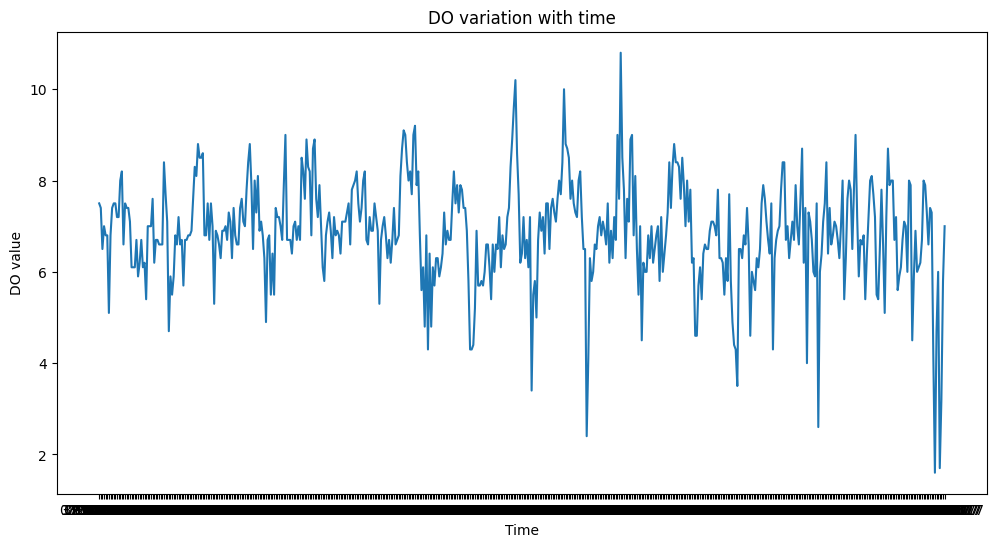

In [7]:
plt.figure(figsize=(12, 6))
plt.plot(df.DO)
plt.xlabel("Time")
plt.ylabel("DO value")
plt.title("DO variation with time")
plt.savefig("initial_plot.png", dpi=500)
plt.show();

In [8]:
X, y = df, df.DO.values
X.shape, y.shape

((523, 2), (523,))

In [9]:
X

,DO,Temp
Date,,
07 01 1990,7.5,29.0
31 07 1990,7.4,29.0
31 08 1990,6.5,26.0
09 10 1990,7.0,27.0
20 09 1990,6.8,29.0
...,...,...
31 07 2017,6.0,29.0
09 03 2017,1.7,29.0
10 02 2017,3.2,29.0


In [10]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
mm = MinMaxScaler()
ss = StandardScaler()

X_trans = ss.fit_transform(X)
y_trans = mm.fit_transform(y.reshape(-1, 1))

In [11]:
# y_trans

In [12]:
# split a multivariate sequence past, future samples (X and y)
def split_sequences(input_sequences, output_sequence, n_steps_in, n_steps_out):
    X, y = list(), list() # instantiate X and y
    for i in range(len(input_sequences)):
        # find the end of the input, output sequence
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out - 1
        # check if we are beyond the dataset
        if out_end_ix > len(input_sequences): break
        # gather input and output of the pattern
        seq_x, seq_y = input_sequences[i:end_ix], output_sequence[end_ix-1:out_end_ix, -1]
        X.append(seq_x), y.append(seq_y)
    return np.array(X), np.array(y)

X_ss, y_mm = split_sequences(X_trans, y_trans, 16, 8)
print(X_ss.shape, y_mm.shape)

(501, 16, 2) (501, 8)


In [13]:
X_ss[0]

array([[ 0.56444551,  1.43893223],
       [ 0.47455908,  1.43893223],
       [-0.33441875,  0.4235123 ],
       [ 0.11501338,  0.76198561],
       [-0.06475947,  1.43893223],
       [-0.06475947,  1.43893223],
       [-1.59282872,  0.76198561],
       [-0.06475947,  0.76198561],
       [ 0.47455908,  0.93122226],
       [ 0.56444551,  0.59274896],
       [ 0.56444551,  0.4235123 ],
       [ 0.29478623, -0.59190763],
       [ 0.29478623, -0.59190763],
       [ 1.01387764, -0.59190763],
       [ 1.19365049, -0.59190763],
       [-0.24453233, -0.59190763]])

In [14]:
# y_trans[99:149].squeeze(1)

In [15]:
X_ss.shape[0]

501

In [16]:
total_samples = len(X)
# wall1 = round(0.60 * X_ss.shape[0])
# wall2 = round(0.80 * X_ss.shape[0])
wall1 = 400
wall2 = 440
X_train = X_ss[:wall1]
X_val = X_ss[wall1:wall2]
X_test = X_ss[wall2:]

y_train = y_mm[:wall1]
y_val = y_mm[wall1:wall2]
y_test = y_mm[wall2:]

print("Training Shape:", X_train.shape, y_train.shape)
print("Validation Shape:", X_val.shape, y_val.shape)
print("Testing Shape:", X_test.shape, y_test.shape)

Training Shape: (400, 16, 2) (400, 8)
Validation Shape: (40, 16, 2) (40, 8)
Testing Shape: (61, 16, 2) (61, 8)


In [17]:
# convert to pytorch tensors
X_train_tensors = torch.tensor(X_train, requires_grad=True).to(torch.float32)
X_val_tensors = torch.tensor(X_val, requires_grad=True).to(torch.float32)
X_test_tensors = torch.tensor(X_test, requires_grad=True).to(torch.float32)

y_train_tensors = torch.tensor(y_train, requires_grad=True).to(torch.float32)
y_val_tensors = torch.tensor(y_val, requires_grad=True).to(torch.float32)
y_test_tensors = torch.tensor(y_test, requires_grad=True).to(torch.float32)

In [18]:
X_train_tensors.shape, y_train_tensors.shape

(torch.Size([400, 16, 2]), torch.Size([400, 8]))

In [19]:
# reshaping to rows, timestamps, features
X_train_tensors_final = torch.reshape(X_train_tensors,
                                      (X_train_tensors.shape[0], 16,
                                       X_train_tensors.shape[2]))
X_val_tensors_final = torch.reshape(X_val_tensors,
                                      (X_val_tensors.shape[0], 16,
                                       X_val_tensors.shape[2]))
X_test_tensors_final = torch.reshape(X_test_tensors,
                                     (X_test_tensors.shape[0], 16,
                                      X_test_tensors.shape[2]))

print("Training Shape:", X_train_tensors_final.shape, y_train_tensors.shape)
print("Validation Shape:", X_val_tensors_final.shape, y_val_tensors.shape)
print("Testing Shape:", X_test_tensors_final.shape, y_test_tensors.shape)


Training Shape: torch.Size([400, 16, 2]) torch.Size([400, 8])
Validation Shape: torch.Size([40, 16, 2]) torch.Size([40, 8])
Testing Shape: torch.Size([61, 16, 2]) torch.Size([61, 8])


In [20]:
X_train_tensors_final

tensor([[[ 0.5644,  1.4389],
         [ 0.4746,  1.4389],
         [-0.3344,  0.4235],
         ...,
         [ 1.0139, -0.5919],
         [ 1.1937, -0.5919],
         [-0.2445, -0.5919]],

        [[ 0.4746,  1.4389],
         [-0.3344,  0.4235],
         [ 0.1150,  0.7620],
         ...,
         [ 1.1937, -0.5919],
         [-0.2445, -0.5919],
         [ 0.5644, -0.9304]],

        [[-0.3344,  0.4235],
         [ 0.1150,  0.7620],
         [-0.0648,  1.4389],
         ...,
         [-0.2445, -0.5919],
         [ 0.5644, -0.9304],
         [ 0.4746, -0.9304]],

        ...,

        [[-0.5142,  1.1005],
         [-0.0648,  0.2543],
         [-0.2445, -0.8627],
         ...,
         [ 0.9240, -0.5919],
         [ 0.6543, -1.7427],
         [ 0.2049, -1.0996]],

        [[-0.0648,  0.2543],
         [-0.2445, -0.8627],
         [ 0.4746, -1.8781],
         ...,
         [ 0.6543, -1.7427],
         [ 0.2049, -1.0996],
         [-0.1546, -0.1857]],

        [[-0.2445, -0.8627],
       

In [21]:
# X_check, y_check = split_sequences(X, y.reshape(-1, 1), 100, 50)
# X_check[-1][0:4]

In [22]:
# y_check[-1]

In [23]:
df.DO.values[-50:]

array([5.4, 6.4, 7.2, 8. , 8.1, 7.7, 7.2, 5.5, 5.4, 6.5, 7.8, 6.6, 5.1,
       7.2, 8.7, 7.9, 8. , 8. , 6.7, 7.2, 5.6, 5.9, 6.1, 6.7, 7.1, 7. ,
       6. , 8. , 7.9, 4.5, 5.9, 6.9, 6. , 6.1, 6.2, 6.7, 8. , 7.9, 7.3,
       6.6, 7.4, 7.3, 4.2, 1.6, 4.7, 6. , 1.7, 3.2, 5.8, 7. ])

In [24]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super().__init__()
        self.num_classes = num_classes # output size
        self.num_layers = num_layers # number of recurrent layers in the lstm
        self.input_size = input_size # input size
        self.hidden_size = hidden_size # neurons in each lstm layer
        # LSTM model
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True) # lstm
        self.fc_1 =  nn.Linear(hidden_size, 128) # fully connected
        self.fc_2 = nn.Linear(128, num_classes) # fully connected last layer
        self.relu = nn.ReLU()

    def forward(self,x):
        # hidden state
        h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size, requires_grad=True)
        # cell state
        c_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size, requires_grad=True)
        # propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) # (input, hidden, and internal state)
        hn = hn.view(-1, self.hidden_size) # reshaping the data for Dense layer next
        out = self.relu(hn)
        out = self.fc_1(out) # first dense
        out = self.relu(out) # relu
        out = self.fc_2(out) # final output
        return out

In [25]:
train_loss_list = []
val_loss_list = []
test_loss_list = []

In [26]:
def training_loop(n_epochs, lstm, optimiser, loss_fn, X_train, y_train, X_val, y_val,
                  X_test, y_test):
    for epoch in range(n_epochs):
        lstm.train()
        outputs = lstm.forward(X_train) # forward pass
        optimiser.zero_grad() # calculate the gradient, manually setting to 0
        # obtain the loss function
        loss = loss_fn(outputs, y_train)
        loss.backward() # calculates the loss of the loss function
        optimiser.step() # improve from loss, i.e backprop
        # test loss
        lstm.eval()
        val_preds = lstm(X_val)
        test_preds = lstm(X_test)
        val_loss = loss_fn(val_preds, y_val)
        test_loss = loss_fn(test_preds, y_test)
        train_loss_list.append(loss.item())
        val_loss_list.append(val_loss.item())
        test_loss_list.append(test_loss.item())
        if epoch % 100 == 0:
            print("Epoch: %d, train loss: %1.5f, test loss: %1.5f" % (epoch,
                                                                      loss.item(),
                                                                      test_loss.item()))

In [27]:
import warnings
warnings.filterwarnings('ignore')

n_epochs = 1000 # 1000 epochs
learning_rate = 0.001 # 0.001 lr

input_size = 2 # number of features
hidden_size = 2 # number of features in hidden state
num_layers = 1 # number of stacked lstm layers

num_classes = 8 # number of output classes

lstm = LSTM(num_classes,
              input_size,
              hidden_size,
              num_layers)

In [28]:
loss_fn = torch.nn.MSELoss()    # mean-squared error for regression
optimiser = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

In [29]:
y_test_tensors.type()

'torch.FloatTensor'

In [30]:
training_loop(n_epochs=n_epochs,
              lstm=lstm,
              optimiser=optimiser,
              loss_fn=loss_fn,
              X_train=X_train_tensors_final,
              y_train=y_train_tensors,
              X_val=X_val_tensors_final,
              y_val=y_val_tensors,
              X_test=X_test_tensors_final,
              y_test=y_test_tensors)

Epoch: 0, train loss: 0.30674, test loss: 0.28088
Epoch: 100, train loss: 0.01254, test loss: 0.02171
Epoch: 200, train loss: 0.01095, test loss: 0.02605
Epoch: 300, train loss: 0.01030, test loss: 0.02529
Epoch: 400, train loss: 0.00990, test loss: 0.02589
Epoch: 500, train loss: 0.00958, test loss: 0.02590
Epoch: 600, train loss: 0.00921, test loss: 0.02589
Epoch: 700, train loss: 0.00902, test loss: 0.02527
Epoch: 800, train loss: 0.00889, test loss: 0.02499
Epoch: 900, train loss: 0.00882, test loss: 0.02473


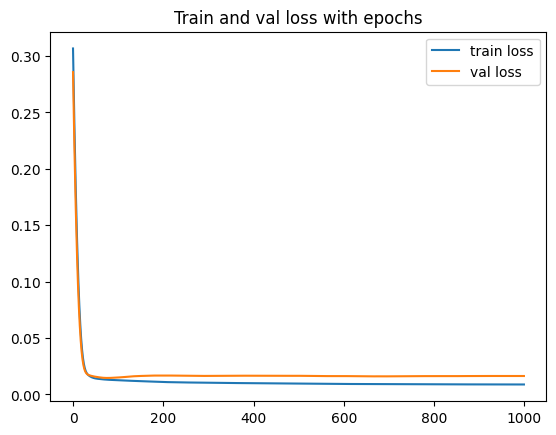

In [31]:
plt.plot(train_loss_list, label='train loss') # actual plot
plt.plot(val_loss_list, label='val loss') # actual plot
plt.title('Train and val loss with epochs')
plt.legend()
plt.savefig("train_test_losses.png", dpi=600)
plt.show()

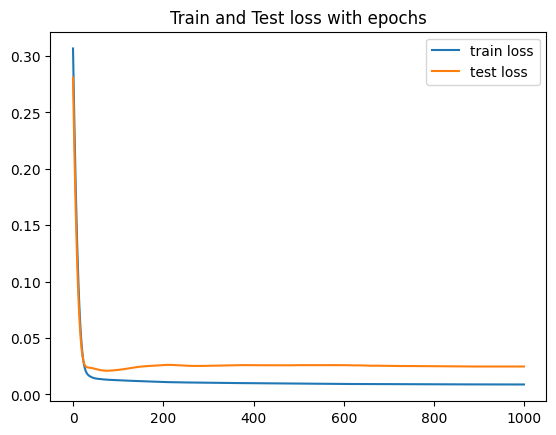

In [32]:
plt.plot(train_loss_list, label='train loss') # actual plot
plt.plot(test_loss_list, label='test loss') # predicted plot
plt.title('Train and Test loss with epochs')
plt.legend()
plt.savefig("train_test_losses.png", dpi=600)
plt.show()

In [33]:
df_X_ss = ss.transform(df) # old transformers
df_y_mm = mm.transform(df.DO.values.reshape(-1, 1)) # old transformers


In [34]:
# split the sequence
df_X_ss, df_y_mm = split_sequences(df_X_ss, df_y_mm, 16, 8)

In [35]:
# converting to tensors
df_X_ss = torch.Tensor(df_X_ss)
df_y_mm = torch.Tensor(df_y_mm)

In [36]:
# reshaping the dataset
df_X_ss = torch.reshape(df_X_ss, (df_X_ss.shape[0], 16, df_X_ss.shape[2]))

In [37]:
train_predict = lstm(df_X_ss) # forward pass
data_predict = train_predict.data.numpy() # numpy conversion
dataY_plot = df_y_mm.data.numpy()

data_predict = mm.inverse_transform(data_predict) # reverse transformation
dataY_plot = mm.inverse_transform(dataY_plot)

In [38]:
train_predict.shape, data_predict.shape, dataY_plot.shape

(torch.Size([501, 8]), (501, 8), (501, 8))

In [39]:
df_X_ss.shape

torch.Size([501, 16, 2])

In [40]:
X_d

,Date
0,01-07-1990
1,31-07-1990
2,31-08-1990
3,10-09-1990
4,20-09-1990
...,...
518,31-07-2017
519,03-09-2017
520,02-10-2017
521,31-10-2017


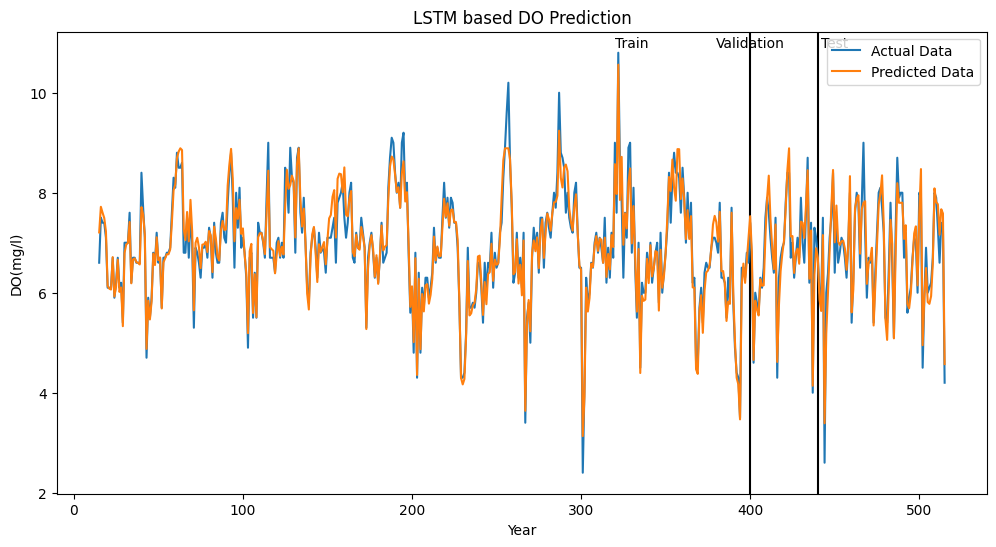

In [41]:
true, preds = [], []
for i in range(len(dataY_plot)):
    true.append(dataY_plot[i][0])
for i in range(len(data_predict)):
    preds.append(data_predict[i][0])

plt.figure(figsize=(12,6)) #plotting
plt.axvline(x=X_d.index[wall1], c='black', linestyle='-') # size of the training set
plt.axvline(x=X_d.index[wall2], c='black', linestyle='-') # size of the training set

plt.annotate('Train', xy=(X_d.index[330], max(true) + 0.1), color='black', fontsize=10, ha='center')
plt.annotate('Validation', xy=(X_d.index[400], max(true) + 0.1), color='black', fontsize=10, ha='center')
plt.annotate('Test', xy=(X_d.index[450], max(true) + 0.1), color='black', fontsize=10, ha='center')

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#9467bd']

plt.plot(X_d.index[15:X_d.shape[0]-7],true, label='Actual Data')  # actual plot
plt.plot(X_d.index[15:X_d.shape[0]-7],preds, label='Predicted Data')
plt.title('LSTM based DO Prediction')
plt.xlabel('Year')  # Add x-axis label
plt.ylabel('DO(mg/l)')  # Add y-axis label
plt.legend()
plt.savefig("whole_plot.png", dpi=1200)
plt.show()

In [42]:
type(true)

list

In [43]:
import sys

In [44]:
len(true)

501

In [45]:
len(preds)

501

In [46]:
preds = np.array(preds)

In [47]:
# Convert the list to a DataFrame
preds_df = pd.DataFrame({'DO': preds})
preds_df.to_csv('9_preds.csv', index=False)

In [48]:
preds[:5]

array([7.2059646, 7.7186956, 7.6006093, 7.494191 , 7.2231164],
      dtype=float32)

In [49]:
r = np.corrcoef(true[:wall1], preds[:wall1])[0, 1]
r_squared = r ** 2
a1 = np.array(true[:wall1], dtype=int)
a2 = np.array(preds[:wall1], dtype=int)
denominator = np.sum((a1 - np.mean(a1)) ** 2)
numerator = np.sum((a2 - a1) ** 2)
nse_val = 1 - numerator / denominator
nse_val
print(f"r: {r}")
print(f"r squared: {r_squared}")
print(f"nse: {nse_val}")

r: 0.9691322009905305
r squared: 0.9392172229967501
nse: 0.829710457095651


In [50]:
r = np.corrcoef(true[wall1:wall2], preds[wall1:wall2])[0, 1]
r_squared = r ** 2
a1 = np.array(true[wall1:wall2], dtype=int)
a2 = np.array(preds[wall1:wall2], dtype=int)
denominator = np.sum((a1 - np.mean(a1)) ** 2)
numerator = np.sum((a2 - a1) ** 2)
nse_val = 1 - numerator / denominator
nse_val
print(f"r: {r}")
print(f"r squared: {r_squared}")
print(f"nse: {nse_val}")

r: 0.9492455428623983
r squared: 0.9010671006441292
nse: 0.7548161120840631


In [51]:
r = np.corrcoef(true[wall2:], preds[wall2:])[0, 1]
r_squared = r ** 2
a1 = np.array(true[wall2:], dtype=int)
a2 = np.array(preds[wall2:], dtype=int)
denominator = np.sum((a1 - np.mean(a1)) ** 2)
numerator = np.sum((a2 - a1) ** 2)
nse_val = 1 - numerator / denominator
nse_val
print(f"r: {r}")
print(f"r squared: {r_squared}")
print(f"nse: {nse_val}")

r: 0.9457384117476593
r squared: 0.8944211434549851
nse: 0.6963015647226174


In [52]:
import pandas as pd
true_df = pd.DataFrame({'DO': true})
true_df.to_csv('true.csv', index=False)